# CS231n Final Project
# Matthew Kaplan and Avery Rogers
# mkaplan1@stanford.edu, averyr@stanford.edu
### For our project, we explore whether appending a segmentation mask to the training data will lead to better scene classification performance versus vanilla scene classification methods.

Note: This was run on Colab Pro, with GPU runtime for cuda, and a High-RAM (25 GB) environment.

## Part 0: Setup the Notebook, Load, and Preprocess the data.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the filename where the project
FOLDERNAME = 'CS231n Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Import sys so we can access utils files with imports.
# ie utils_ade20k in next code block.
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Run below cell to clear up RAM.
import gc
gc.collect()

59

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 50
print('using device:', device)

using device: cuda


Here, we load the training, validation, and test data from Google Drive for speed and efficiency purposes. We had to pull the data from the dataset using a large dictionary that the MIT Researchers behind the dataset helped setup. For examples of how to parse through the dataset, see the ade20k_starter.ipynb notebook.

To see our work pulling training, validation, and test sets for the top 50 most popularly seen classes, see the Python scripts ade20k_scene_parser.py and load_ade20k_data.py scripts that we authored from scratch. This took up the bulk of our efforts up to the week following the milestone.

In [ ]:
train_data_path = '/content/drive/MyDrive/CS231n Project/Datasets/x_train.npy'
x_train = torch.tensor(np.load(train_data_path)).double()

val_data_path = '/content/drive/MyDrive/CS231n Project/Datasets/x_val.npy'
x_val = torch.tensor(np.load(val_data_path)).double()

test_data_path = '/content/drive/MyDrive/CS231n Project/Datasets/x_test.npy'
x_test = torch.tensor(np.load(test_data_path)).double()

y_train_seg_path = '/content/drive/MyDrive/CS231n Project/Datasets/y_train_seg.npy'
y_train_seg = torch.tensor(np.load(y_train_seg_path)).double()

y_val_seg_path = '/content/drive/MyDrive/CS231n Project/Datasets/y_val_seg.npy'
y_val_seg = torch.tensor(np.load(y_val_seg_path)).double()

y_test_seg_path = '/content/drive/MyDrive/CS231n Project/Datasets/y_test_seg.npy'
y_test_seg = torch.tensor(np.load(y_test_seg_path)).double()

y_train_scenes_path = '/content/drive/MyDrive/CS231n Project/Datasets/y_train_scenes.npy'
y_train_scenes = torch.tensor(np.load(y_train_scenes_path)).long()

y_val_scenes_path = '/content/drive/MyDrive/CS231n Project/Datasets/y_val_scenes.npy'
y_val_scenes = torch.tensor(np.load(y_val_scenes_path)).long()

y_test_scenes_path = '/content/drive/MyDrive/CS231n Project/Datasets/y_test_scenes.npy'
y_test_scenes = torch.tensor(np.load(y_test_scenes_path)).long()

In [ ]:
# Verify shapes here.
print('x_train: {}'.format(x_train.shape))
print('x_val: {}'.format(x_val.shape))
print('x_test: {}'.format(x_test.shape))
print('y_train_seg: {}'.format(y_train_seg.shape))
print('y_val_seg: {}'.format(y_val_seg.shape))
print('y_test_seg: {}'.format(y_test_seg.shape))
print('y_train_scenes: {}'.format(y_train_scenes.shape))
print('y_val_scenes: {}'.format(y_val_scenes.shape))
print('y_test_scenes: {}'.format(y_test_scenes.shape))

x_train: torch.Size([13181, 128, 128, 3])
x_val: torch.Size([1369, 128, 128, 3])
x_test: torch.Size([1211, 128, 128, 3])
y_train_seg: torch.Size([13181, 128, 128, 1])
y_val_seg: torch.Size([1369, 128, 128, 1])
y_test_seg: torch.Size([1211, 128, 128, 1])
y_train_scenes: torch.Size([13181])
y_val_scenes: torch.Size([1369])
y_test_scenes: torch.Size([1211])


In [ ]:
# WARNING: ONLY RUN THIS CELL ONCE

BATCH_SIZE = 64

# Preprocess the x_data
NUM_TRAIN = x_train.shape[0]
NUM_VAL = x_val.shape[0]
NUM_TEST = x_test.shape[0]


# Subtract mean
x_train_mean = torch.mean(x_train, dim=0)
x_train -= x_train_mean
x_val -= x_train_mean
x_test -= x_train_mean

# Divide by std (255)
x_train /= 255
x_val /= 255
x_test /= 255

# Permute the axes for pytorch layers
x_train = x_train.permute(0, 3, 1, 2)
x_val = x_val.permute(0, 3, 1, 2)
x_test = x_test.permute(0, 3, 1, 2)
y_train_seg = y_train_seg.permute(0, 3, 1, 2)
y_val_seg = y_val_seg.permute(0, 3, 1, 2)
y_test_seg = y_test_seg.permute(0, 3, 1, 2)

# Keep track of these values (will need to use to preprocess y)
y_train_mean = torch.mean(y_train_seg, dim=0)
# std
y_train_std = torch.std(y_train_seg, dim=0)

## Part 1: Baseline Model

For this model, we want to map raw image pixels to a scene class (vanilla scene classification). This will give us a baseline to see if adding a segmentation mask to the input will improve performance. For our baseline model, we will use a pretrained deep network ResNet50.

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 50, bias=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The below functions had the high-level architecture provided by CS231n Course Staff in the PyTorch notebook from Assignment 2, but we made big changes to accomodate the different dataset and manually pulling random batches and getting accuracy on the different splits of data. This applies to the various check accuracy and train models that will appear later in the notebook in later parts.

In [ ]:
def check_accuracy(x, y, model, input_string): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    if input_string == 'Test':
      num_iterations = int(NUM_TEST / BATCH_SIZE) + 1
    else:
      num_iterations = int(NUM_VAL / BATCH_SIZE) + 1  
    with torch.no_grad():
        for i in range(num_iterations):
          # Need to get x and y
          if input_string == 'Train':
            batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, replace=False)
            x_batch = x[batch_indices].type(dtype)
            y_batch = y[batch_indices].type(dtype).long()
          else:
            if i == num_iterations - 1:
              x_batch = x[num_samples:].type(dtype)
              y_batch = y[num_samples:].type(dtype).long()
            else:
              x_batch = x[num_samples:num_samples + BATCH_SIZE].type(dtype)
              y_batch = y[num_samples:num_samples + BATCH_SIZE].type(dtype).long()
          x_batch = x_batch.to(device=device, dtype=dtype)  # move to device, e.g. GPU
          y_batch = y_batch.to(device=device, dtype=torch.long)
          scores = model(x_batch)
          _, preds = scores.max(1)
          num_correct += (preds == y_batch).sum()
          num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('{}: Got {} / {} correct ({})'.format(input_string, num_correct, num_samples, round(100 * acc, 2)))

Similar to the function above, the below functions had the high-level structure provided by the train34 function from Assignment 2 of CS231n, with major changes to accomodate manually pulling the mini-batches of data and accomodating the data structure specific to the ADE20k dataset we pulled.

In [ ]:
def train_baseline(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_arr = []
    num_iter = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(int(NUM_TRAIN / BATCH_SIZE)):
            num_iter.append(e * int(NUM_TRAIN / BATCH_SIZE) + t)
            batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, 
                                                        replace=False)
            x = x_train[batch_indices].type(dtype)
            y = y_train_scenes[batch_indices].type(dtype)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            loss_arr.append(loss)
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(x_train, y_train_scenes, model, 'Train')
                check_accuracy(x_val, y_val_scenes, model, 'Val')
                print()
    plt.plot(num_iter, loss_arr)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss by Iteration')

In [ ]:
def train_baseline_overfit(model, optimizer, epochs=1):
  loss_arr = []
  num_iter = []
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, 
                                                        replace=False)
  x = x_train[batch_indices].type(dtype)
  y = y_train_scenes[batch_indices].type(dtype)
  for e in range(epochs):
    for t in range(int(NUM_TRAIN / BATCH_SIZE)):
        num_iter.append(e * int(NUM_TRAIN / BATCH_SIZE) + t)
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        if (t % print_every == 0):
          _, preds = scores.max(1)
          preds = preds
          num_correct = (preds == y).sum()
          num_samples = preds.size(0)
          acc = float(num_correct) / num_samples
          print('{}: Got {} / {} correct ({})'.format('Train', num_correct, num_samples, round(100 * acc, 2)))
          print('Loss = {}'.format(round(float(loss), 2)))
        
            
        loss_arr.append(loss)
        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
  plt.plot(num_iter, loss_arr)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Loss by Iteration')

First, let's see if we can overfit ResNet50 on a small batch of training examples (just to verify the model can learn given our setup):

Train: Got 7 / 64 correct (10.94)
Loss = 3.92
Train: Got 64 / 64 correct (100.0)
Loss = 0.0
Train: Got 64 / 64 correct (100.0)
Loss = 0.0
Train: Got 64 / 64 correct (100.0)
Loss = 0.0
Train: Got 64 / 64 correct (100.0)
Loss = 0.0


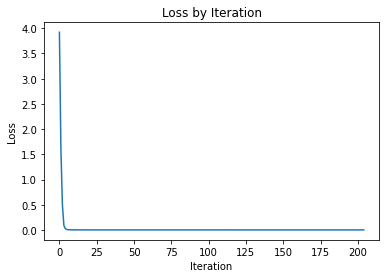

In [ ]:
optimizer = optim.Adam(resnet50.parameters(), lr=.001)
train_baseline_overfit(resnet50, optimizer, epochs=1)

The good news is that ResNet50 successfully overfit on a small batch of training examples. It's now time to train on all training examples using minibatch Adam updates. This will give us a baseline accuracy going forward:

Iteration 0, loss = 10.4495
Train: Got 244 / 1408 correct (17.33)
Val: Got 185 / 1369 correct (13.51)

Iteration 50, loss = 2.5067
Train: Got 402 / 1408 correct (28.55)
Val: Got 375 / 1369 correct (27.39)

Iteration 100, loss = 2.4426
Train: Got 464 / 1408 correct (32.95)
Val: Got 374 / 1369 correct (27.32)

Iteration 150, loss = 2.0351
Train: Got 539 / 1408 correct (38.28)
Val: Got 389 / 1369 correct (28.41)

Iteration 200, loss = 1.9970
Train: Got 593 / 1408 correct (42.12)
Val: Got 421 / 1369 correct (30.75)

Iteration 0, loss = 2.1965
Train: Got 598 / 1408 correct (42.47)
Val: Got 426 / 1369 correct (31.12)

Iteration 50, loss = 1.7546
Train: Got 619 / 1408 correct (43.96)
Val: Got 463 / 1369 correct (33.82)

Iteration 100, loss = 1.7253
Train: Got 684 / 1408 correct (48.58)
Val: Got 475 / 1369 correct (34.7)

Iteration 150, loss = 1.6847
Train: Got 680 / 1408 correct (48.3)
Val: Got 466 / 1369 correct (34.04)

Iteration 200, loss = 1.4853
Train: Got 768 / 1408 correct (54.55)
Val:

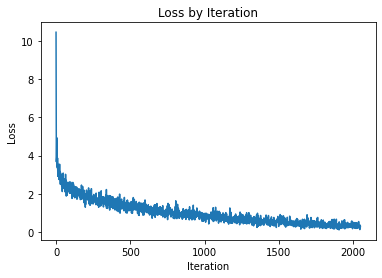

In [ ]:
optimizer = optim.Adam(resnet50.parameters(), lr=.001, weight_decay=1e-4)
train_baseline(resnet50, optimizer, epochs=10)

In [ ]:
# Check final validation accuracy:
check_accuracy(x_val, y_val_scenes, resnet50, 'Val')

Val: Got 571 / 1369 correct (41.71)


In [ ]:
# Check final test accuracy:
check_accuracy(x_test, y_test_scenes, resnet50, 'Test')

Test: Got 645 / 1211 correct (53.26)


After manual hyperparameter tuning, training for 10 epochs on a learning rate of $.001$ and L2 Regularization strength of $1 \times 10^{-4}$, our baseline accuracy on the test set is $53.26\%$.

Note: Inspiration for .001 learning rate came from [1]:

[1]: S. Mishra, T. Yamasaki and H. Imaizumi, "Improving image classifiers for small datasets by learning rate adaptations," 2019 16th International Conference on Machine Vision Applications (MVA), 2019, pp. 1-6, doi: 10.23919/MVA.2019.8757890.

## Part 2: Best Possible Performance Model (Gold Standard).

Here, we will concatenate the provided segmentation mask channel to the raw image pixel as an input. The segmentation masks have shape $N \times 1 \times H \times W$ and the raw images have shape $N \times 3 \times H \times W$. After concatenating on the channel axis, we will have an input of shape $N \times 4 \times H \times W$ which will serve as our input. We then train this input on a pretrained ResNet18 model that we cross validate, and the resulting scene classification accuracy serves as our gold standard for the accuracy our approach can achieve.

In [ ]:
# First, undo preprocessing:
x_train *= 255
x_val *= 255
x_test *= 255

x_train += x_train_mean.permute((2, 0, 1))
x_val += x_train_mean.permute((2, 0, 1))
x_test += x_train_mean.permute((2, 0, 1))

In [ ]:
# Watch out for RAM. RAM will be problematic potentially with all these
# permutations of the training examples.

img_seg_train = torch.cat((x_train, y_train_seg), dim=1)
img_seg_val = torch.cat((x_val, y_val_seg), dim=1)
img_seg_mean = torch.mean(img_seg_train, dim=0)
img_seg_std = torch.std(img_seg_train, dim=0)
img_seg_train -= img_seg_mean
img_seg_val -= img_seg_mean
img_seg_train /= img_seg_std
img_seg_val /= img_seg_std

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.reshape((N, -1))

At the start of our project, we tried to build our own model to achieve our gold standard. We end up using a cross-validated pretrained ResNet18 model to achieve this, but we still wanted to include the work we did below:

In [ ]:
# Here is model:
input_channel = 3
channel_1 = 92
channel_2 = 64
channel_3 = 55
channel_4 = 45
input_linear = 1125
channel_5 = 32
hidden_1 = 750
hidden_2 = 250
num_classes = 50

model = nn.Sequential(
    nn.Conv2d(4, channel_1, 5, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(channel_1),
    nn.Conv2d(channel_1, channel_2, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(channel_2),
    nn.Conv2d(channel_2, channel_3, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(channel_3),
    nn.Conv2d(channel_3, channel_4, 3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3),
    nn.BatchNorm2d(channel_4),
    Flatten(),
    nn.Linear(input_linear, hidden_1),
    nn.ReLU(),
    nn.Dropout(p = .6),
    nn.BatchNorm1d(hidden_1),
    nn.Linear(hidden_1, hidden_2),
    nn.ReLU(),
    nn.Linear(hidden_2, num_classes),
)

In [ ]:
def check_accuracy(x, y, model, input_string): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    if input_string == 'Test':
      num_iterations = int(NUM_TEST / BATCH_SIZE) + 1
    else:
      num_iterations = int(NUM_VAL / BATCH_SIZE) + 1  
    with torch.no_grad():
        for i in range(num_iterations):
          # Need to get x and y
          if input_string == 'Train':
            batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, replace=False)
            x_batch = x[batch_indices].type(dtype)
            y_batch = y[batch_indices].type(dtype).long()
          else:
            if i == num_iterations - 1:
              x_batch = x[num_samples:].type(dtype)
              y_batch = y[num_samples:].type(dtype).long()
            else:
              x_batch = x[num_samples:num_samples + BATCH_SIZE].type(dtype)
              y_batch = y[num_samples:num_samples + BATCH_SIZE].type(dtype).long()
          x_batch = x_batch.to(device=device, dtype=dtype)  # move to device, e.g. GPU
          y_batch = y_batch.to(device=device, dtype=torch.long)
          scores = model(x_batch)
          _, preds = scores.max(1)
          num_correct += (preds == y_batch).sum()
          num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('{}: Got {} / {} correct ({})'.format(input_string, num_correct, num_samples, round(100 * acc, 2)))
        return round(100 * acc, 2)

In [ ]:
def train_dual(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_arr = []
    num_iter = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(int(NUM_TRAIN / BATCH_SIZE)):
            num_iter.append(e * int(NUM_TRAIN / BATCH_SIZE) + t)
            batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, 
                                                        replace=False)
            x = img_seg_train[batch_indices].type(dtype)
            y = y_train_scenes[batch_indices].type(dtype)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            loss_arr.append(loss)
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(img_seg_train, y_train_scenes, model, 'Train')
                check_accuracy(img_seg_val, y_val_scenes, model, 'Val')
                print()
    plt.plot(num_iter, loss_arr)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss by Iteration')

In [ ]:
def train_dual_overfit(model, optimizer, epochs=1):
  loss_arr = []
  num_iter = []
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, 
                                                        replace=False)
  x = img_seg_train[batch_indices].type(dtype)
  y = y_train_scenes[batch_indices].type(dtype)
  for e in range(epochs):
    for t in range(int(NUM_TRAIN / BATCH_SIZE)):
        num_iter.append(e * int(NUM_TRAIN / BATCH_SIZE) + t)
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        if (t % print_every == 0):
          _, preds = scores.max(1)
          preds = preds
          num_correct = (preds == y).sum()
          num_samples = preds.size(0)
          acc = float(num_correct) / num_samples
          print('{}: Got {} / {} correct ({})'.format('Train', num_correct, num_samples, round(100 * acc, 2)))
          print('Loss = {}'.format(round(float(loss), 2)))
        
            
        loss_arr.append(loss)
        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
  plt.plot(num_iter, loss_arr)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Loss by Iteration')

Train: Got 2 / 64 correct (3.12)
Loss = 3.95
Train: Got 64 / 64 correct (100.0)
Loss = 0.01
Train: Got 62 / 64 correct (96.88)
Loss = 0.06
Train: Got 64 / 64 correct (100.0)
Loss = 0.02
Train: Got 64 / 64 correct (100.0)
Loss = 0.0


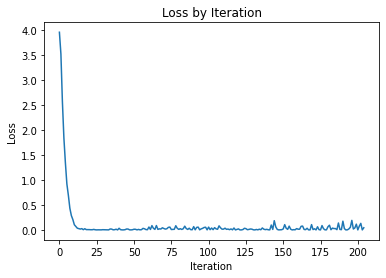

In [ ]:
optimizer = optimizer = optim.Adam(model.parameters(), lr=5e-3)
train_dual_overfit(model, optimizer, epochs=1)

Iteration 0, loss = 18.8047
Train: Got 274 / 1408 correct (19.46)
Val: Got 268 / 1369 correct (19.58)

Iteration 50, loss = 2.5936
Train: Got 517 / 1408 correct (36.72)
Val: Got 442 / 1369 correct (32.29)

Iteration 100, loss = 2.1734
Train: Got 525 / 1408 correct (37.29)
Val: Got 486 / 1369 correct (35.5)

Iteration 150, loss = 2.3676
Train: Got 563 / 1408 correct (39.99)
Val: Got 521 / 1369 correct (38.06)

Iteration 200, loss = 1.8704
Train: Got 587 / 1408 correct (41.69)
Val: Got 537 / 1369 correct (39.23)

Iteration 0, loss = 2.6057
Train: Got 588 / 1408 correct (41.76)
Val: Got 514 / 1369 correct (37.55)

Iteration 50, loss = 1.6593
Train: Got 660 / 1408 correct (46.88)
Val: Got 570 / 1369 correct (41.64)

Iteration 100, loss = 2.0947
Train: Got 646 / 1408 correct (45.88)
Val: Got 574 / 1369 correct (41.93)

Iteration 150, loss = 1.3912
Train: Got 677 / 1408 correct (48.08)
Val: Got 599 / 1369 correct (43.75)

Iteration 200, loss = 1.9805
Train: Got 680 / 1408 correct (48.3)
Val:

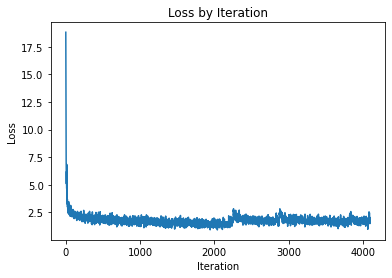

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=8e-3)
train_dual(model, optimizer, epochs=20)

In [ ]:
# Check final validation accuracy:
check_accuracy(img_seg_val, y_val_scenes, model, 'Val')

Val: Got 580 / 1369 correct (42.37)


42.37

In [ ]:
# Check final test accuracy:
img_seg_test = torch.cat((x_test, y_test_seg), dim=1)
img_seg_test -= img_seg_mean
img_seg_test /= img_seg_std
check_accuracy(img_seg_test, y_test_scenes, model, 'Test')

Test: Got 576 / 1211 correct (47.56)


47.56

While our model we built was close to the baseline, the final accuracy did not beat the baseline so we had to pivot and use a pretrained model. Below we load ResNet18, cross-validate on epochs and regularization strength. We used ResNet18 because quicker training so easier cross validation.

In [ ]:
# resnet50 = models.resnet50(pretrained=True)
# resnet50.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# resnet50.fc = nn.Linear(in_features=2048, out_features=50, bias=True)

In [ ]:
# For quicker hyperparameter tuning
resnet18 = models.resnet18(pretrained=True)
# Adjust first layer to take in 4 channels instead of 3.
resnet18.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Adjust last layer to output 50 classes instead of 1000.
resnet18.fc = nn.Linear(in_features=512, out_features=50, bias=True)

Again, make sure we can overfit on the small batch of training examples.

Train: Got 0 / 64 correct (0.0)
Loss = 3.97
Train: Got 64 / 64 correct (100.0)
Loss = 0.0
Train: Got 64 / 64 correct (100.0)
Loss = 0.0
Train: Got 64 / 64 correct (100.0)
Loss = 0.0
Train: Got 64 / 64 correct (100.0)
Loss = 0.0


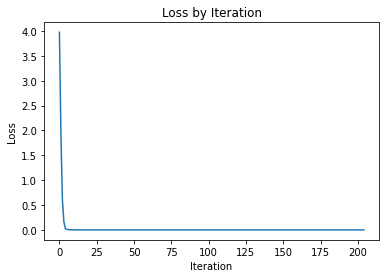

In [ ]:
optimizer = optim.Adam(resnet18.parameters(), lr=.001)
train_dual_overfit(resnet18, optimizer)

Now, cross-validate the ResNet18 models on different numbers of epochs and regularization strengths (we found the model to be overfitting, but regularization didn't always translate to better validation performance so perhaps lowering epochs better means of preventing overfitting).

Iteration 0, loss = 4.1686
Train: Got 111 / 1408 correct (7.88)
Val: Got 119 / 1369 correct (8.69)

Iteration 50, loss = 1.6299
Train: Got 600 / 1408 correct (42.61)
Val: Got 541 / 1369 correct (39.52)

Iteration 100, loss = 1.5864
Train: Got 660 / 1408 correct (46.88)
Val: Got 477 / 1369 correct (34.84)

Iteration 150, loss = 1.4557
Train: Got 723 / 1408 correct (51.35)
Val: Got 570 / 1369 correct (41.64)

Iteration 200, loss = 1.4583
Train: Got 811 / 1408 correct (57.6)
Val: Got 612 / 1369 correct (44.7)

Iteration 0, loss = 1.2664
Train: Got 751 / 1408 correct (53.34)
Val: Got 578 / 1369 correct (42.22)

Iteration 50, loss = 1.1697
Train: Got 833 / 1408 correct (59.16)
Val: Got 618 / 1369 correct (45.14)

Iteration 100, loss = 1.2037
Train: Got 894 / 1408 correct (63.49)
Val: Got 651 / 1369 correct (47.55)

Iteration 150, loss = 0.8438
Train: Got 866 / 1408 correct (61.51)
Val: Got 603 / 1369 correct (44.05)

Iteration 200, loss = 1.1836
Train: Got 827 / 1408 correct (58.74)
Val: Go

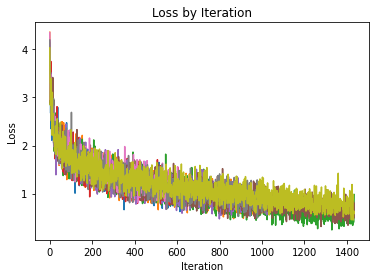

In [ ]:
reg_strength = [3e-4, 5e-4, 7e-4]
epochs = [3, 5, 7]
best_model = None
best_accuracy = 0
best_epoch = None
for reg in reg_strength:
  for e in epochs:
    resnet18 = models.resnet18(pretrained=True)
    resnet18.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resnet18.fc = nn.Linear(in_features=512, out_features=50, bias=True)
    optimizer = optim.Adam(resnet18.parameters(), lr=.001, weight_decay=reg)
    train_dual(resnet18, optimizer, epochs=e)
    val_accuracy = check_accuracy(img_seg_val, y_val_scenes, resnet18, 'Val')
    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      best_model = resnet18
      best_epoch = e

print('Best accuracy is {}'.format(best_accuracy))
print('Best number of epochs is {}'.format(best_epoch))

We found from trial and error that actually training on more epochs led to slightly better performance, so continue to train:

Iteration 0, loss = 0.7886
Train: Got 1050 / 1408 correct (74.57)
Val: Got 643 / 1369 correct (46.97)

Iteration 50, loss = 0.8903
Train: Got 1050 / 1408 correct (74.57)
Val: Got 620 / 1369 correct (45.29)

Iteration 100, loss = 0.5983
Train: Got 1060 / 1408 correct (75.28)
Val: Got 606 / 1369 correct (44.27)

Iteration 150, loss = 0.6880
Train: Got 1084 / 1408 correct (76.99)
Val: Got 576 / 1369 correct (42.07)

Iteration 200, loss = 1.1823
Train: Got 1130 / 1408 correct (80.26)
Val: Got 658 / 1369 correct (48.06)

Iteration 0, loss = 0.7516
Train: Got 1090 / 1408 correct (77.41)
Val: Got 601 / 1369 correct (43.9)

Iteration 50, loss = 0.5296
Train: Got 1114 / 1408 correct (79.12)
Val: Got 614 / 1369 correct (44.85)

Iteration 100, loss = 0.5568
Train: Got 1121 / 1408 correct (79.62)
Val: Got 601 / 1369 correct (43.9)

Iteration 150, loss = 0.8903
Train: Got 1121 / 1408 correct (79.62)
Val: Got 635 / 1369 correct (46.38)

Iteration 200, loss = 0.6851
Train: Got 1176 / 1408 correct (83

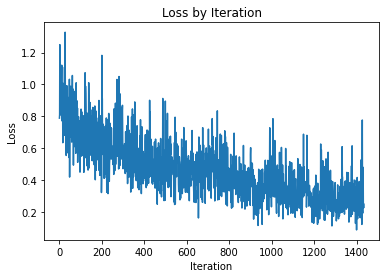

In [ ]:
# Continue to train for double the epochs on best_model.
optimizer = optim.Adam(best_model.parameters(), lr=.001, weight_decay=.0005)
train_dual(best_model, optimizer, epochs=best_epoch)

In [ ]:
# Check final validation accuracy:
check_accuracy(img_seg_val, y_val_scenes, best_model, 'Val')

Val: Got 674 / 1369 correct (49.23)


49.23

In [ ]:
# Check final test accuracy:
# Don't need first 3 lines if you trained my own model above.
check_accuracy(img_seg_test, y_test_scenes, best_model, 'Test')

Test: Got 727 / 1211 correct (60.03)


60.03

Here, we achieved our gold standard accuracy: $49.23\%$ on the validation set and $60.03\%$ on the test set! This is great news, as we see appending the segmentation mask to the training data can lead to better scene classification performance than our baseline if the segmentation mask is well constructed (we achieved roughly $7\%$ better performance on both validation and test sets). Having a better gold standard is evidence that our approach has validity. We now try to beat our baseline by producing the segmentation mask instead of using the provided one below.

In [ ]:
# torch.save(best_model, '/content/drive/MyDrive/CS231n Project/Datasets/best_model.pt')

In [ ]:
# For quick debugging, load a trained model from previous run to avoid waiting for 
# model to retrain. NOTE: in final run before submission this will NOT be used.
# best_model = torch.load('/content/drive/MyDrive/CS231n Project/Datasets/best_model.pt')

In [ ]:
# After performing above, run this cell until RAM
# in top right goes down.
img_seg_train = None
img_seg_val = None
img_seg_test = None
gc.collect()

13346

## Part 3: Produce Segmentation Mask from Raw Image.

In this part, we use a Fully Connected ResNet50 model that can produce a segmentation mask from raw pixels. This segmentation mask will then serve as our input in our model in part 4.

In [ ]:
# Re preprocess the x_data though it should already be permuted.
# Subtract mean
x_train_mean = torch.mean(x_train, dim=0)
x_train -= x_train_mean
x_val -= x_train_mean
x_test -= x_train_mean

# Divide by std (255)
x_train /= 255
x_val /= 255
x_test /= 255

In [ ]:
# Now, figure out how many classes there are.
num_seg_classes = int(np.max(np.concatenate((np.unique(y_train_seg), 
                            np.unique(y_val_seg), np.unique(y_test_seg)))) + 1)
print(num_seg_classes)

253


Here, we load a FCN ResNet50 model meant for segmentation.

In [ ]:
# Load resnet segmentation model
seg_model = models.segmentation.fcn_resnet50(pretrained=False, 
                      progress=True, num_classes=num_seg_classes, aux_loss=None)

In [ ]:
def train_seg_overfit(model, optimizer, epochs=1):
  loss_arr = []
  num_iter = []
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, 
                                                        replace=False)
  x = x_train[batch_indices].type(dtype)
  y = y_train_seg[batch_indices].type(dtype)
  y = y.reshape((y.shape[0], y.shape[2], y.shape[3]))
  x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
  y = y.to(device=device, dtype=torch.long)

  for e in range(epochs):
    for t in range(int(NUM_TRAIN / BATCH_SIZE)):
        num_iter.append(e * int(NUM_TRAIN / BATCH_SIZE) + t)
        model.train()  # put model to training mode
        
        scores = model(x)
        loss = F.cross_entropy(scores['out'], y, reduction='none')

        if (t % print_every == 0):
          print('Loss = {}'.format(round(float(loss.mean()), 2)))
        
        loss_arr.append(loss.mean())
        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward(torch.ones(loss.shape).cuda())

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
  plt.plot(num_iter, loss_arr)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Loss by Iteration')

In [ ]:
def train_seg(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_arr = []
    num_iter = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(int(NUM_TRAIN / BATCH_SIZE)):
            num_iter.append(e * int(NUM_TRAIN / BATCH_SIZE) + t)
            batch_indices = np.random.choice(range(NUM_TRAIN), size=BATCH_SIZE, 
                                                        replace=False)
            x = x_train[batch_indices].type(dtype)
            y = y_train_seg[batch_indices].type(dtype)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            y = y.reshape((y.shape[0], y.shape[2], y.shape[3]))

            scores = model(x)
            loss = F.cross_entropy(scores['out'], y, reduction='none')
            
            loss_arr.append(loss.mean())
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward(torch.ones(loss.shape).cuda())

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.mean()))
                print()
    plt.plot(num_iter, loss_arr)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss by Iteration')

In [ ]:
# optimizer = optim.Adam(seg_model.parameters(), lr=.001)
# train_seg_overfit(seg_model, optimizer)

We trained the model using the code above. Training took roughly 30 mins an epoch so we had to train in bunches. You can see from the code below that we load the model that had been trained for 4 epochs and we decided to train again for 4 epochs. This was necessary to not get kicked off runtime for using too many Colab resources.

In [ ]:
seg_model = torch.load('/content/drive/MyDrive/CS231n Project/Datasets/seg_model.pt')

Iteration 0, loss = 3.4828

Iteration 50, loss = 3.4849

Iteration 100, loss = 3.3970

Iteration 150, loss = 3.5966

Iteration 200, loss = 3.3314

Iteration 0, loss = 3.5779

Iteration 50, loss = 3.2957

Iteration 100, loss = 3.3302

Iteration 150, loss = 3.1253

Iteration 200, loss = 3.5021

Iteration 0, loss = 3.4917

Iteration 50, loss = 3.3966

Iteration 100, loss = 3.2166

Iteration 150, loss = 3.3100

Iteration 200, loss = 3.2531

Iteration 0, loss = 3.2423

Iteration 50, loss = 3.1640

Iteration 100, loss = 3.1660

Iteration 150, loss = 3.1734

Iteration 200, loss = 3.1085



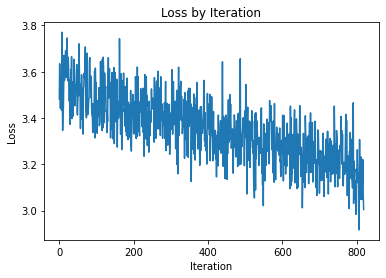

In [ ]:
# Train for 4 more epochs
optimizer = optim.Adam(seg_model.parameters(), lr=.001, weight_decay=1e-5)
train_seg(seg_model, optimizer, epochs=4)

We save after training so in future iterations we would not have to retrain.

In [ ]:
# Save after more training.
torch.save(seg_model, '/content/drive/MyDrive/CS231n Project/Datasets/seg_model.pt')

In [ ]:
gc.collect()

2387

# Part 4: Running Test Set Through Trained Model in Part 3 then Part 2 to Get Final Scene Classifcation Accuracy.

Put it together. Running the images through the trained model in part 3 then concatenating the output from that model with original image as an input into model from part 2 should score well.

Using the same network as part 2, plugging in the segmentation mask created in part 3 instead of the given segmentation masks should ideally outperform part 1. This will only outperform part 1 in 2 cases:

1) Part 2 outperforms Part 1 (it does) and \\
2) The performance of the model in part 3 is good enough to produce a strong segmentation mask as input into the model (we will see).

First, we run the raw test images through the model from part 3 that produces the segmentation mask, and append this to the raw test images for input into the model from part 2.

In [ ]:
seg_model.eval()
best_model.eval()
img_seg_input = torch.zeros((NUM_TEST, 1, x_test.shape[2], x_test.shape[3]))
# x_test is already preprocessed with -median and /std
num_iterations = int(NUM_TEST / BATCH_SIZE) + 1
num_samples = 0
for i in range(num_iterations):
  if i == num_iterations - 1:
    x_batch = x_test[num_samples:].type(dtype)
    y_batch = y_test_scenes[num_samples:].type(dtype).long()
  else:
    x_batch = x_test[num_samples:num_samples + BATCH_SIZE].type(dtype)
    y_batch = y_test_scenes[num_samples:num_samples + BATCH_SIZE].type(dtype).long()
  x_batch = x_batch.to(device=device, dtype=dtype)  # move to device, e.g. GPU
  y_batch = y_batch.to(device=device, dtype=torch.long)
  scores = seg_model(x_batch)
  _, preds = torch.max(scores['out'], dim=1)
  if i == num_iterations - 1:
    img_seg_input[num_samples:,0,:,:] = preds
  else:
    img_seg_input[num_samples:num_samples +  BATCH_SIZE,0,:,:] = preds
  num_samples += BATCH_SIZE
# Feed through seg_model on eval mode to get NUM_TRAIN produced segmentation masks
# Unprocess x_test, concatentate seg masks to x_test, then divde img_seg_mean and
# img_seg_std. Feed through part 2 model and evaluate result.

In [ ]:
# Unprocess x_test to press img_seg_input
x_test *= 255
x_test += x_train_mean
img_seg_input = torch.cat((x_test, img_seg_input), dim=1)
img_seg_input -= img_seg_mean
img_seg_input /= img_seg_std

Now, we run through the model from part 2 to obtain our final test accuracy:

In [ ]:
# Put through model:
print('Final test accuracy: ')
print()
check_accuracy(img_seg_input, y_test_scenes, best_model, 'Test')

Final test accuracy: 

Test: Got 585 / 1211 correct (48.31)


48.31

As seen, we unfortunately did not beat the baseline of roughly $53\%$, but we were not far off at $48.31\%$. As we discuss in the writeup, we are skeptical that the segmentation mask actually had good data integrity (each pixel representing a unique class at that one channel). Considering our skepticism about the segmentation mask's underlying structure, our ability to get close to baseline allows us to still believe this approach can lead to better classification (as proven by part 2's superior performance to baseline).